# Recommendation Systems

- Recommendation systems are machine learning algorithms that suggest relevant items to users based on patterns in the data.
- They're used extensively by Netflix, Youtube, Amazon, etc..
- Rating: represents a rating or preference score that a user would give to an item, which can be used to generate personalized recommendation.
- Types:
    - Collaborative Filtering:
        - User-Based: recommends items based on preferences of similar users.
        - Item-Based: recommends items similar to ones the user already likes.
        - One challenge with collaborative filtering is:
            - the "cold start" problem (not having enough ratings for new users/items)
            - Solution: provide a survey to gather ratings from new users when they first sign up
    - Hybrid Recommender System:
        - Combines multiple approaches
    - Knowledge-Based
        - Uses explicit rules and domain knowledge

## Collaborative Filtering

- They recommend items by analyzing user preferences collected from a large database of users
- They predict future preferences based on historical patterns, such as movies, apparel, etc..
- For example, if 2 users have a similar taste i movies, the system might recommend a new movie to one user that the other has favorably rated.
- It uses the concept of cosine similarity:
$$cos(\theta) = (A * B) / (||A|| * ||B||)$$
 

- Here A and B are vectors that represent user ratings
- A smaller angle means a higher cosine similarity, which also indicates more closely aligned preferences.

![cos](https://kdb.ai/files/2024/01/similarity-768x348.png)

![user](https://www.oreilly.com/api/v2/epubs/9781789807943/files/assets/d22941f0-29d2-4c0e-8a79-5f065e5f527e.png)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotx

plt.style.use(matplotx.styles.dracula)

from sklearn.metrics.pairwise import cosine_similarity

In [32]:
path = '/Users/bassel_instructor/Documents/Datasets/'

df = pd.read_csv(path+'rating.csv')
df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### EDA

In [33]:
df.shape

(7813737, 3)

- We shouldn't have -1 rating. so it needs to be dropped (could be missing ratings data)
- Let's inspect all the rating classes

<Axes: xlabel='rating', ylabel='count'>

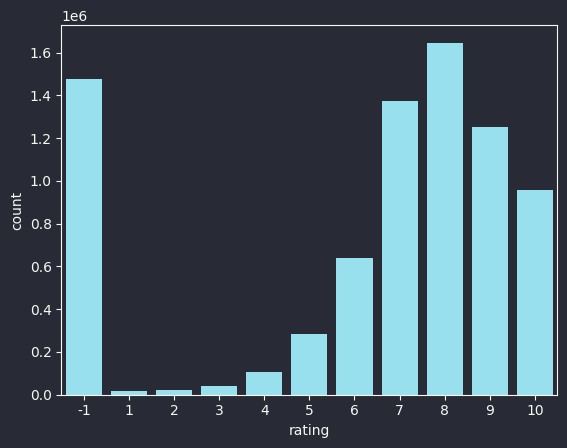

In [34]:
sns.countplot(data=df,x='rating')

In [35]:
df = df[df['rating'] != -1]
df['rating'].value_counts()

rating
8     1646019
7     1375287
9     1254096
10     955715
6      637775
5      282806
4      104291
3       41453
2       23150
1       16649
Name: count, dtype: int64

<Axes: xlabel='rating', ylabel='count'>

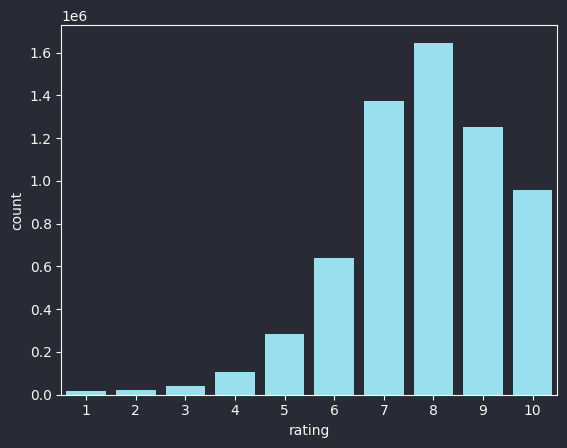

In [36]:
sns.countplot(data=df,x='rating')

In [37]:
df.shape

(6337241, 3)

In [38]:
df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [39]:
# check the number of users in the data
len(df['user_id'].unique())

69600

In [40]:
#check the number of anime ids
df['anime_id'].nunique()

9927

In [41]:
# get the number of ratings per user
ratings_per_user = df.groupby('user_id')[['rating']].count()
#get top 10
ratings_per_user.nlargest(10, 'rating')

,rating
user_id,
42635,3747
53698,2905
57620,2689
59643,2632
51693,2621
45659,2462
7345,2429
12431,2348
65840,2215


In [42]:
ratings_per_user.nsmallest(10, 'rating')

,rating
user_id,
2,1
9,1
15,1
35,1
59,1
70,1
86,1
113,1
114,1


In [43]:
ratings_per_user.mean()

rating    91.052313
dtype: float64

The average user has rated 91 items, this indicates good engagement and data sample.

array([[<Axes: title={'center': 'rating'}>]], dtype=object)

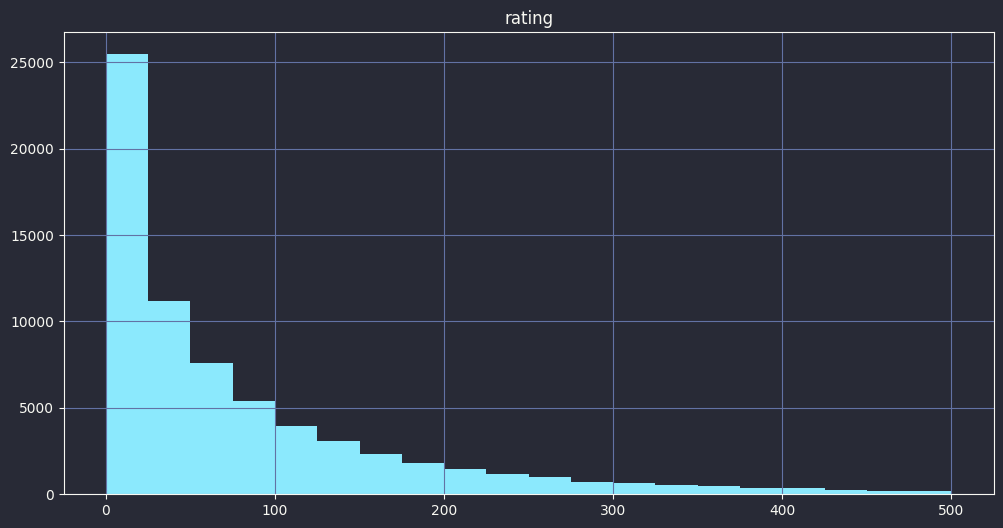

In [44]:
# plot histogram with users' number of ratings and trim our high values
ratings_per_user.hist(bins=20, range=(0,500),figsize=(12,6))

<Axes: xlabel='rating'>

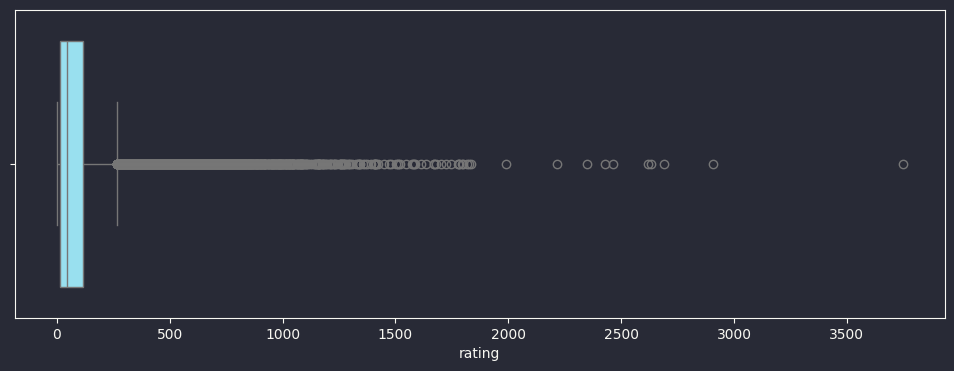

In [45]:
plt.figure(figsize=(12,4))
sns.boxplot(x=ratings_per_user['rating'])

- The histogram and box plot show right-skewed distribution, which means most users have rated less than 100
- A very small number of users have rated between 100 and 500
- We have users with over 1500 ratings (these are very rare)

In [46]:
# get the number of ratings per item/anime
ratings_per_anime = df.groupby('anime_id')[['rating']].count()
#get top 10
ratings_per_anime.nlargest(10, 'rating')

,rating
anime_id,
1535,34226
11757,26310
16498,25290
1575,24126
6547,23565
226,23528
20,22071
5114,21494
121,21332


In [47]:
ratings_per_anime.mean()

rating    638.384305
dtype: float64

- on average each anime title receives approximately 638 ratings
- The top 10 anime in the list above represent the most popular ones in the platform

array([[<Axes: title={'center': 'rating'}>]], dtype=object)

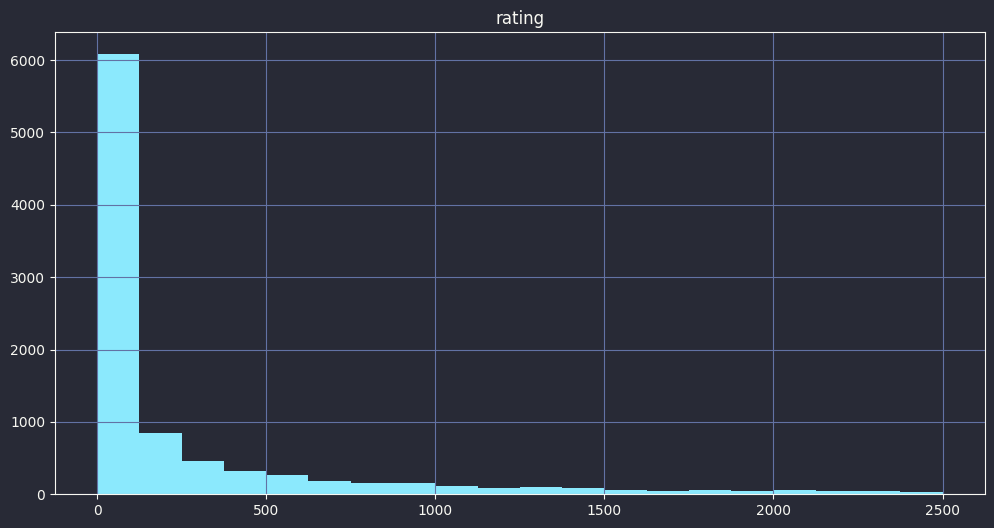

In [48]:
ratings_per_anime.hist(bins=20,figsize=(12,6), range=(0,2500))

The highest freq of anime title ratings is between 0 and 200

Next, we can choose a threshold to get the anime that's popular based on number of ratings. e.g. 1000

In [49]:
filtered_ratings_per_anime = ratings_per_anime[ratings_per_anime['rating']>=1000]
filtered_ratings_per_anime.shape

(1462, 1)

In [50]:
# extract the indices (anime IDS) of the popular anime
popular_anime = filtered_ratings_per_anime.index.to_list()
popular_anime[:20]

[1, 5, 6, 7, 15, 16, 18, 19, 20, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 43]

In [51]:
filtered_ratings_per_user = ratings_per_user[ratings_per_user['rating']>=500]
filtered_ratings_per_user.shape

(1365, 1)

In [52]:
# extract the indices (user IDS) of the prolific users
prolific_users = filtered_ratings_per_user.index.to_list()
prolific_users[:20]

[226,
 271,
 294,
 392,
 446,
 478,
 661,
 741,
 771,
 786,
 958,
 1019,
 1103,
 1145,
 1176,
 1191,
 1287,
 1344,
 1456,
 1497]

In [53]:
# using the original dataset, filter the ratings to include only ratings from prolific users
filtered_ratings = df[df['user_id'].isin(prolific_users)]

#calculate the length of the filtered ratings
print(f'{len(filtered_ratings):,}')

1,005,314


### Build The User-Item Matrix

In [54]:
# create a pivot table to construct the user-item matrix
#for missing values where a user did not give a rating, use 0
rating_matrix = filtered_ratings.pivot_table(index='user_id', columns='anime_id', values='rating', fill_value=0)

rating_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
226,8,0,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271,0,0,0,0,0,0,0,0,0,0,...,0,0,10,0,0,0,0,0,0,0
294,7,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
392,7,0,7,0,0,0,0,0,7,0,...,0,0,0,0,0,0,0,0,0,0
446,9,8,9,0,0,0,0,0,0,10,...,0,0,9,0,0,0,0,0,0,0


> Make sure your original scale starts from 1. Otherwise, the system won't be able to differentiate between missing value and low rating of 0.

Now we can perform cosine similarity

In [55]:
user_similarity = cosine_similarity(rating_matrix)
user_similarity[:20]

array([[1.        , 0.31052381, 0.36980954, ..., 0.36236069, 0.33636818,
        0.30650698],
       [0.31052381, 1.        , 0.268366  , ..., 0.290322  , 0.2870974 ,
        0.22791986],
       [0.36980954, 0.268366  , 1.        , ..., 0.3498557 , 0.41170536,
        0.37794637],
       ...,
       [0.44314134, 0.34138384, 0.38558941, ..., 0.43251097, 0.30175858,
        0.26105111],
       [0.38532263, 0.32372477, 0.39422563, ..., 0.33228578, 0.35176558,
        0.29250128],
       [0.40461084, 0.37844862, 0.31425118, ..., 0.34552816, 0.28354403,
        0.33189806]])

To read the output above, we need to convert it into a dataframe

In [56]:
user_similarity_df = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)
user_similarity_df

user_id,226,271,294,392,446,478,661,741,771,786,...,73234,73272,73286,73340,73356,73362,73378,73395,73499,73502
user_id,,,,,,,,,,,,,,,,,,,,,
226,1.000000,0.310524,0.369810,0.368844,0.479172,0.351496,0.339471,0.453386,0.397297,0.384594,...,0.290858,0.362299,0.413587,0.434253,0.309391,0.288167,0.453607,0.362361,0.336368,0.306507
271,0.310524,1.000000,0.268366,0.221096,0.342823,0.376454,0.306231,0.345585,0.357868,0.493646,...,0.272166,0.159041,0.307801,0.289110,0.096752,0.346684,0.357435,0.290322,0.287097,0.227920
294,0.369810,0.268366,1.000000,0.358606,0.387980,0.394491,0.360027,0.419455,0.361109,0.470477,...,0.361611,0.282967,0.362801,0.413025,0.353574,0.340823,0.451359,0.349856,0.411705,0.377946
392,0.368844,0.221096,0.358606,1.000000,0.397043,0.307310,0.293243,0.316196,0.396577,0.314374,...,0.286049,0.340013,0.342345,0.465727,0.322202,0.266032,0.434801,0.360945,0.304120,0.242900
446,0.479172,0.342823,0.387980,0.397043,1.000000,0.377938,0.405816,0.430414,0.404201,0.430761,...,0.357724,0.353429,0.402775,0.431481,0.314192,0.292046,0.481478,0.401871,0.340195,0.335937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73362,0.288167,0.346684,0.340823,0.266032,0.292046,0.450861,0.272566,0.358541,0.437512,0.412681,...,0.334768,0.207235,0.350239,0.349987,0.238223,1.000000,0.396227,0.318946,0.332661,0.355931
73378,0.453607,0.357435,0.451359,0.434801,0.481478,0.465542,0.359494,0.462871,0.504422,0.487243,...,0.431488,0.297537,0.450135,0.470631,0.343550,0.396227,1.000000,0.439854,0.456134,0.454755
73395,0.362361,0.290322,0.349856,0.360945,0.401871,0.404292,0.332429,0.377932,0.367900,0.397738,...,0.366442,0.264322,0.403430,0.380225,0.244898,0.318946,0.439854,1.000000,0.347211,0.319619


Next, we can build a process that extract the top n users that are similar to each user. Then, recommend their associated anime.

In [57]:
def recommend_anime(user_id, user_item_matrix, user_similarity_df, top_n=5): #here we're making top 5 by default, but can be changed
    #get the user's ratings
    user_ratings = user_item_matrix.loc[user_id]

    #find similar users based on the cosine similarity matrix
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)

    #extract anime recommendations
    #build an empty series
    recommendations = pd.Series(dtype='float64')

    for similar_user in similar_users.index[1:]: #the range here is skip the first item since it's always the user themselves
        #get the ratings of the similar user
        similar_user_ratings = user_item_matrix.loc[similar_user]

        #find the anime where the similar gave a rating, but the user in scope hasn't 
        recommended_anime = similar_user_ratings[similar_user_ratings > 0].index.difference(user_ratings[user_ratings>0].index)

        #Append those anime to the recommendation
        recommendations = pd.concat([recommendations, similar_user_ratings.loc[recommended_anime]])

    #sort recommendations by rating and return non-duplicated outcome - you can specify top n here
    recommendations = recommendations.sort_values(ascending=False).drop_duplicates().head(top_n)

    return recommendations
    

In [58]:
user_similarity_df.head(20).index[:20]

Index([ 226,  271,  294,  392,  446,  478,  661,  741,  771,  786,  958, 1019,
       1103, 1145, 1176, 1191, 1287, 1344, 1456, 1497],
      dtype='int64', name='user_id')

In [72]:
user_id_ = 1191
recommend_anime_output = recommend_anime(user_id_, rating_matrix, user_similarity_df) #5 will be the default top n
print(f'User {user_id_} recommendation:\n {recommend_anime_output}')

User 1191 recommendation:
 1086     10
23319     9
1220      8
15039     7
23171     6
dtype: int64


- The results suggest a list of recommended anime for user 1191, along with predicted ratings for the user.
- For example, item 1086 is the mostly recommended for user 1191 with 10/10 predicted rating from the user. Item 23319 comes after.

In [73]:
user_id_ = 226
recommend_anime_output = recommend_anime(user_id_, rating_matrix, user_similarity_df) #5 will be the default top n
print(f'User {user_id_} recommendation:\n {recommend_anime_output}')

User 226 recommendation:
 24031    10
6964      9
31964     8
6951      7
654       6
dtype: int64


- The results suggest a list of recommended anime for user 226, along with predicted ratings for the user.
- For example, item 24031 is the mostly recommended for user 226 with 10/10 predicted rating from the user.

In [74]:
df_anime = pd.read_csv(path+'anime.csv')
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


We can use the list above, to find the exact name and genre of the recommended anime

Recommendation for User 226:

In [75]:
recommend_anime_names = df_anime[df_anime['anime_id'].isin(recommend_anime_output.index)]
#print(f'User {user_id_} recommendation:\n {recommend_anime_names}')
recommend_anime_names

,anime_id,name,genre,type,episodes,rating,members
178,31964,Boku no Hero Academia,"Action, Comedy, School, Shounen, Super Power",TV,13,8.36,282002
2038,654,Galaxy Angel 3 Specials,"Comedy, Sci-Fi",Special,2,7.37,2574
2361,24031,Denki-gai no Honya-san,"Comedy, Seinen, Slice of Life",TV,12,7.28,61228
2389,6951,Yu☆Gi☆Oh!: Chou Yuugou! Toki wo Koeta Kizuna,"Adventure, Game, Shounen",Special,1,7.28,18651
3930,6964,Yuu☆Yuu☆Hakusho Picture Drama,"Action, Comedy, Demons, Martial Arts, Shounen",Special,1,6.85,4697


# Item Based

In [76]:
dataset = {
    'user1': {'Mindhunter': 5, 'You': 3, 'Dexter': 3, 'Mr. Robot': 3, 'True Detective': 2, 'Twin Peaks': 3},
    'user2': {'Mindhunter': 5, 'You': 3, 'Mr. Robot': 5, 'Dexter': 5, 'Twin Peaks': 3, 'True Detective': 3},
    'user3': {'Mindhunter': 2, 'Dexter': 5, 'Mr. Robot': 3, 'Twin Peaks': 4},
    'user4': {'Dexter': 5, 'Twin Peaks': 4, 'Mr. Robot': 4},
    'user5': {'Mindhunter': 4, 'You': 4, 'Dexter': 4, 'Twin Peaks': 3, 'True Detective': 2},
    'user6': {'Mindhunter': 3, 'Dexter': 4, 'Twin Peaks': 3, 'Mr. Robot': 5, 'True Detective': 3},
    'user7': {'Dexter': 4, 'True Detective': 1, 'Mr. Robot': 4}
}

In [77]:
df = pd.DataFrame(dataset).T.fillna(0)
df

,Mindhunter,You,Dexter,Mr. Robot,True Detective,Twin Peaks
user1,5.0,3.0,3.0,3.0,2.0,3.0
user2,5.0,3.0,5.0,5.0,3.0,3.0
user3,2.0,0.0,5.0,3.0,0.0,4.0
user4,0.0,0.0,5.0,4.0,0.0,4.0
user5,4.0,4.0,4.0,0.0,2.0,3.0
user6,3.0,0.0,4.0,5.0,3.0,3.0
user7,0.0,0.0,4.0,4.0,1.0,0.0


In [78]:
#now we transpose where rows are tv shows and columns are users
df = df.T
df

,user1,user2,user3,user4,user5,user6,user7
Mindhunter,5.0,5.0,2.0,0.0,4.0,3.0,0.0
You,3.0,3.0,0.0,0.0,4.0,0.0,0.0
Dexter,3.0,5.0,5.0,5.0,4.0,4.0,4.0
Mr. Robot,3.0,5.0,3.0,4.0,0.0,5.0,4.0
True Detective,2.0,3.0,0.0,0.0,2.0,3.0,1.0
Twin Peaks,3.0,3.0,4.0,4.0,3.0,3.0,0.0


In [80]:
item_similarity = cosine_similarity(df)
#the output is a numpy array, so we need to convert it back into df for readability
item_similarity_df = pd.DataFrame(item_similarity, index=df.index, columns=df.index)
item_similarity_df

,Mindhunter,You,Dexter,Mr. Robot,True Detective,Twin Peaks
Mindhunter,1.000000,0.887575,0.763825,0.686304,0.909398,0.804978
You,0.887575,1.000000,0.597081,0.411597,0.759113,0.623918
Dexter,0.763825,0.597081,1.000000,0.913908,0.753778,0.928841
Mr. Robot,0.686304,0.411597,0.913908,1.000000,0.769800,0.812494
True Detective,0.909398,0.759113,0.753778,0.769800,1.000000,0.700140
Twin Peaks,0.804978,0.623918,0.928841,0.812494,0.700140,1.000000


In [89]:
def recommend_shows(user, top_n=3):

    user_ratings = dataset[user]

    recommendations = {}

    for show, rating in user_ratings.items():
        # focus on highly rated shows
        if rating > 3:
            similar_shows = item_similarity_df[show].drop(index=show).sort_values(ascending=False)

            for similar_show, similarity in similar_shows.items(): #get unwatched shows
                if similar_show not in user_ratings: # if the user did not rate, then they did not see the show
                    if similar_show not in recommendations:
                        recommendations[similar_show] = 0
                    recommendations[similar_show] += similarity * rating

    # sort the recommendation by highest predicted score
    sorted_recommendations = sorted(recommendations.items(),key= lambda x: x[1], reverse=True)

    return [show for show, _ in sorted_recommendations[:top_n]]

In [90]:
user_ = 'user3'

recommend_shows(user_)

['True Detective', 'You']